In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [85]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 5

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "interm/events"
SIDES_DIR = BASE_DIR / "interm/sides"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_FEATURES.pkl"

## Loading Data

In [86]:
%%time
df = pd.read_pickle(RESAMPLED_FILE_PATH)

CPU times: user 747 μs, sys: 4.35 ms, total: 5.09 ms
Wall time: 20 ms


In [87]:
df.shape

(74711, 7)

In [88]:
df.head()

,timestamp,open,high,low,close,volume,spread
0,2024-01-01 22:00:00,140.8730,140.8730,140.8655,140.8655,1.200000e+10,0.045750
1,2024-01-01 22:05:00,140.8660,140.8670,140.8660,140.8670,4.200000e+09,0.050000
2,2024-01-01 22:10:00,140.8700,140.8950,140.8655,140.8655,3.842000e+10,0.034941
3,2024-01-01 22:15:00,140.8660,140.8685,140.8660,140.8685,1.050000e+10,0.049250
4,2024-01-01 22:20:00,140.8705,140.8785,140.8675,140.8785,1.616200e+11,0.043016


In [89]:
df["timestamp"] = df["timestamp"].astype("datetime64[s]")
df = df.set_index("timestamp")
df = df.dropna()

## Calculating MACD

In [90]:
import pandas_ta as ta

FAST = 12 #(45 min)
SLOW = 26 #(180 min)
SIGNAL = 9

df.ta.macd(fast=FAST, slow=SLOW, signal=SIGNAL, append=True)

df['future_return'] = np.log(df['close']).diff().shift(-1)

## Generate Signals

df['signal'] = np.where(df[f"MACD_{FAST}_{SLOW}_{SIGNAL}"] > df[f'MACDs_{FAST}_{SLOW}_{SIGNAL}'], 1, -1)

df['signal']

## Simple Testing

df['strategy_return'] = df['signal'] * df['future_return']

r = df['strategy_return']
profit_factor = r[r>0].sum() / r[r<0].abs().sum()
sharpe_ratio = r.mean() / r.std()

print('Profit Factor:', profit_factor)
print('Sharpe Ratio:', sharpe_ratio)

Profit Factor: 0.9951054606553362
Sharpe Ratio: -0.0014131006093896152


## Optimize the strategy

This strategy has 3 parameters: fast, slow, signal

We can optimize the strategy by finding the best combination

Top 10 Parameter Combinations by Sharpe Ratio:
 fast  slow  signal  profit_factor  sharpe_ratio  total_return  win_rate  num_trades
    5    34       9       1.012654      0.003621      0.105302  0.488583       74710
    9    34       5       1.012654      0.003621      0.105302  0.488583       74710
    9    20       7       1.012362      0.003539      0.102890  0.488020       74710
   13    22       5       1.012242      0.003504      0.101897  0.487512       74710
    9    20       9       1.012232      0.003501      0.101809  0.487967       74710
    7    20       9       1.012123      0.003470      0.100907  0.487980       74710
    7    38       7       1.012078      0.003458      0.100538  0.487431       74710
    5    22      13       1.011985      0.003431      0.099767  0.487512       74710
    7    24      11       1.011604      0.003323      0.096612  0.487525       74710
    5    32      11       1.011602      0.003322      0.096596  0.487190       74710


Top 10 Parameter

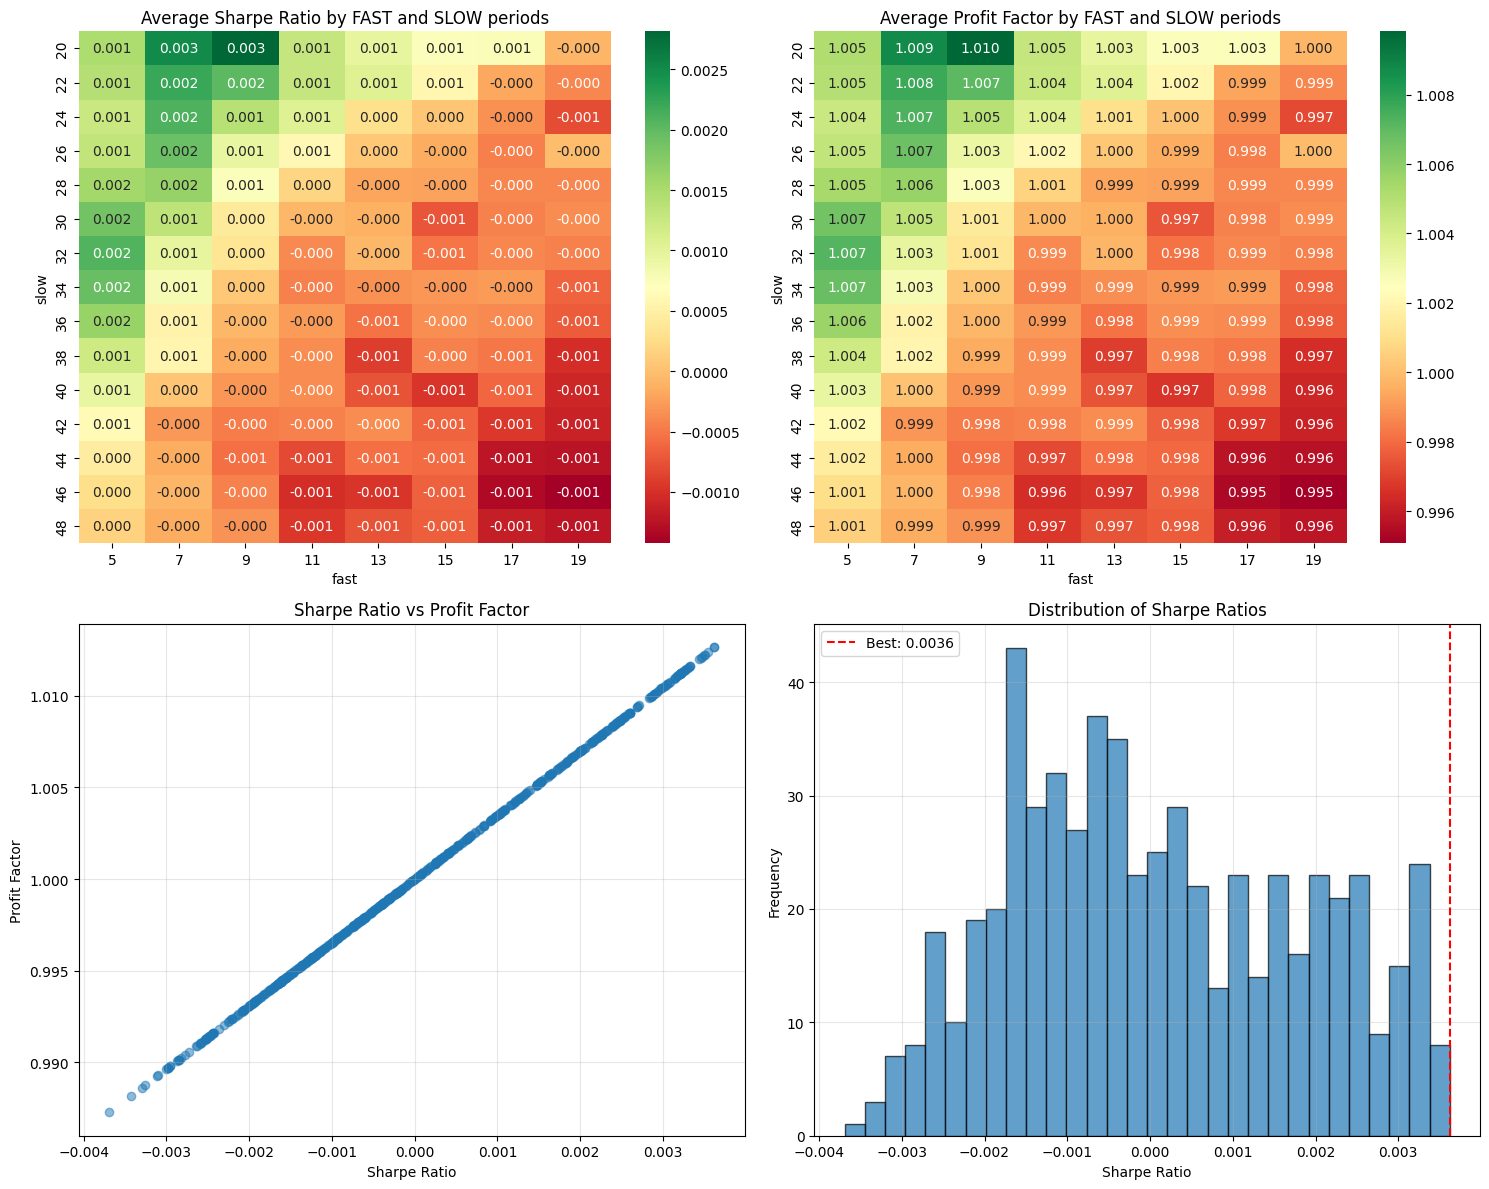

In [91]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter ranges to test
fast_range = range(5, 20, 2)      # 8, 10, 12, 14, 16, 18
slow_range = range(20, 50, 2)     # 20, 22, 24, 26, 28, 30, 32, 34
signal_range = range(5, 15, 2)    # 5, 7, 9, 11, 13

# Store results
results = []

# Grid search optimization
for fast, slow, signal in product(fast_range, slow_range, signal_range):
    # Skip invalid combinations where fast >= slow
    if fast >= slow:
        continue
    
    # Create a copy of dataframe for testing
    df_test = df.copy()
    
    # Calculate MACD
    df_test.ta.macd(fast=fast, slow=slow, signal=signal, append=True)
    
    # Calculate future returns
    df_test['future_return'] = np.log(df_test['close']).diff().shift(-1)
    
    # Generate signals
    df_test['signal'] = np.where(
        df_test[f"MACD_{fast}_{slow}_{signal}"] > df_test[f'MACDs_{fast}_{slow}_{signal}'], 
        1, -1
    )
    
    # Calculate strategy returns
    df_test['strategy_return'] = df_test['signal'] * df_test['future_return']
    
    # Calculate metrics
    r = df_test['strategy_return'].dropna()
    
    if len(r) > 0 and r[r < 0].abs().sum() != 0:
        profit_factor = r[r > 0].sum() / r[r < 0].abs().sum()
        sharpe_ratio = r.mean() / r.std() if r.std() != 0 else 0
        total_return = r.sum()
        win_rate = len(r[r > 0]) / len(r)
        
        results.append({
            'fast': fast,
            'slow': slow,
            'signal': signal,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'total_return': total_return,
            'win_rate': win_rate,
            'num_trades': len(r)
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by Sharpe Ratio (or any metric you prefer)
results_df = results_df.sort_values('sharpe_ratio', ascending=False)

# Display top 10 parameter combinations
print("Top 10 Parameter Combinations by Sharpe Ratio:")
print(results_df.head(10).to_string(index=False))

print("\n" + "="*80 + "\n")

# Display top 10 by Profit Factor
print("Top 10 Parameter Combinations by Profit Factor:")
print(results_df.sort_values('profit_factor', ascending=False).head(10).to_string(index=False))

# Get the best parameters
best_params = results_df.iloc[0]
print("\n" + "="*80 + "\n")
print("Best Parameters (by Sharpe Ratio):")
print(f"FAST: {int(best_params['fast'])}")
print(f"SLOW: {int(best_params['slow'])}")
print(f"SIGNAL: {int(best_params['signal'])}")
print(f"Sharpe Ratio: {best_params['sharpe_ratio']:.4f}")
print(f"Profit Factor: {best_params['profit_factor']:.4f}")
print(f"Total Return: {best_params['total_return']:.4f}")
print(f"Win Rate: {best_params['win_rate']:.2%}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Heatmap: Sharpe Ratio vs Fast/Slow (averaged over signal values)
pivot_sharpe = results_df.groupby(['fast', 'slow'])['sharpe_ratio'].mean().reset_index()
pivot_sharpe = pivot_sharpe.pivot(index='slow', columns='fast', values='sharpe_ratio')
sns.heatmap(pivot_sharpe, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0])
axes[0, 0].set_title('Average Sharpe Ratio by FAST and SLOW periods')

# 2. Heatmap: Profit Factor vs Fast/Slow
pivot_pf = results_df.groupby(['fast', 'slow'])['profit_factor'].mean().reset_index()
pivot_pf = pivot_pf.pivot(index='slow', columns='fast', values='profit_factor')
sns.heatmap(pivot_pf, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 1])
axes[0, 1].set_title('Average Profit Factor by FAST and SLOW periods')

# 3. Scatter plot: Sharpe vs Profit Factor
axes[1, 0].scatter(results_df['sharpe_ratio'], results_df['profit_factor'], alpha=0.5)
axes[1, 0].set_xlabel('Sharpe Ratio')
axes[1, 0].set_ylabel('Profit Factor')
axes[1, 0].set_title('Sharpe Ratio vs Profit Factor')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of Sharpe Ratios
axes[1, 1].hist(results_df['sharpe_ratio'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(best_params['sharpe_ratio'], color='red', linestyle='--', 
                    label=f"Best: {best_params['sharpe_ratio']:.4f}")
axes[1, 1].set_xlabel('Sharpe Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Sharpe Ratios')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reproduce the strategy with optimized parameters

In [92]:
import pandas_ta as ta

FAST = 9 #(45 min)
SLOW = 20 #(100 min)
SIGNAL = 9

df.ta.macd(fast=FAST, slow=SLOW, signal=SIGNAL, append=True)

df['future_return'] = np.log(df['close']).diff().shift(-1)

## Generate Signals

df['signal'] = np.where(df[f"MACD_{FAST}_{SLOW}_{SIGNAL}"] > df[f'MACDs_{FAST}_{SLOW}_{SIGNAL}'], 1, -1)

df['signal']

## Simple Testing

df['strategy_return'] = df['signal'] * df['future_return']

r = df['strategy_return']
profit_factor = r[r>0].sum() / r[r<0].abs().sum()
sharpe_ratio = r.mean() / r.std()

print('Profit Factor:', profit_factor)
print('Sharpe Ratio:', sharpe_ratio)

Profit Factor: 1.012231629581061
Sharpe Ratio: 0.0035013513644815077


## Finding Cross Points

找到跨越的時間點（t_events）

In [93]:
df['signal'].value_counts()

signal
-1    37887
 1    36824
Name: count, dtype: int64

In [94]:
# find crossover events
t_events = df.index[df['signal'] != df['signal'].shift(1)]
t_events

DatetimeIndex(['2024-01-01 22:00:00', '2024-01-02 00:15:00',
               '2024-01-02 00:50:00', '2024-01-02 01:30:00',
               '2024-01-02 02:05:00', '2024-01-02 02:35:00',
               '2024-01-02 03:10:00', '2024-01-02 03:25:00',
               '2024-01-02 03:30:00', '2024-01-02 06:25:00',
               ...
               '2024-12-30 12:55:00', '2024-12-30 13:50:00',
               '2024-12-30 14:20:00', '2024-12-30 14:30:00',
               '2024-12-30 15:40:00', '2024-12-30 17:25:00',
               '2024-12-30 19:20:00', '2024-12-30 20:25:00',
               '2024-12-30 21:35:00', '2024-12-30 23:55:00'],
              dtype='datetime64[s]', name='timestamp', length=6943, freq=None)

## Labeling Sides

黃金交叉與死亡交叉

In [95]:
sides = pd.Series(df['signal'].loc[t_events], index=t_events, name='side')
sides

timestamp
2024-01-01 22:00:00   -1
2024-01-02 00:15:00    1
2024-01-02 00:50:00   -1
2024-01-02 01:30:00    1
2024-01-02 02:05:00   -1
                      ..
2024-12-30 17:25:00   -1
2024-12-30 19:20:00    1
2024-12-30 20:25:00   -1
2024-12-30 21:35:00    1
2024-12-30 23:55:00   -1
Name: side, Length: 6943, dtype: int64

In [96]:
sides.value_counts()

side
-1    3472
 1    3471
Name: count, dtype: int64

## Saving to disk

In [97]:
SIDE_NAME = f"MACDCross_{FAST}_{SLOW}_{SIGNAL}"

In [98]:
SIDE_FILE_PATH = SIDES_DIR / f"{RESAMPLED_NAME}-{SIDE_NAME}.pkl"
SIDE_FILE_PATH

PosixPath('../data/interm/sides/USDJPY-5m-20240101-20241231-MACDCross_9_20_9.pkl')

In [99]:
sides.to_pickle(SIDE_FILE_PATH)